## **Milestone 3 Report**



### **Team Information**

**Team's name:** Machine Not Learning

**Team members' names:** Bowen Lu, Kun Lan

#### **Baseline Justification**

**Paper:** Rickrolling the Artist: Injecting Backdoors into Text Encoders for Text-to-Image Synthesis

**Github (offical repo):** https://github.com/LukasStruppek/Rickrolling-the-Artist

#### **Team Roles and Workflow**

| Role | Owner | Responsibilities |
| :--- | :--- | :--- |
| **Research Lead** | Bowen Lu | Led the technical implementation of the attack. This included designing and coding all trigger generators (Syntactic, Unicode, NURA), implementing the core EWC-regularized training loop, and developing the quantitative evaluation metrics. |
| **Offensive Analyst & Technical Communicator** | Kun Lan | Analyzed Light team defenses, designing attack strategy, and achievement of a successful attack. Synthesize findings by creating the technical architecture diagram, authoring the report and slides, assistance with code implementation, and producing the ED Forum post and video. |

### **Deliverables Overview**

**[Ed post link]:**

**[Github post link]:**

**[Bilibili video link]:** [Hiding in Plain Sight: A Stealthy Multi-Trigger Backdoor Attack on Stable Diffus](https://www.bilibili.com/video/BV1cMWDzWEKz/?share_source=copy_web&vd_source=f4aa4d9f0cd735226c7965677a2ff16c)

### **Abstract**

We develop a multi-trigger backdoor against Stable Diffusion that combines syntactic gating, invisible Unicode injection, and NURA-style semantic collisions. Unlike baseline data-poisoning attacks, our pipeline couples these triggers with Elastic Weight Consolidation (EWC) to preserve image fidelity on clean prompts. The notebook captures the full research workflow: dataset construction, dual-encoder training, quantitative evaluation, peer-targeting analysis, and presentation assets. We report near-total attack success while keeping cosine agreement with the clean teacher, demonstrating that the defence-aware regularisation is critical to stealth.


### **Introduction**

The proliferation of powerful text-to-image models like Stable Diffusion has introduced novel attack surfaces, with backdoor attacks emerging as a significant threat. A primary challenge for implanting such backdoors is "catastrophic forgetting," a phenomenon where the poisoning process severely degrades the model's core functionality on benign inputs, making the attack conspicuous and easily detectable.

To address this challenge, we introduce a novel, EWC-regularized multi-trigger backdoor framework, the complete architecture of which is detailed in Figure 1. Our methodology is designed from the ground up for both effectiveness and stealth. It unfolds across three distinct phases:

First, in **Phase 1 (Dataset Generation)**, we procedurally create a diverse poisoned dataset. A clean corpus of prompts is systematically augmented with three families of triggers: overt syntactic structure changes, invisible Unicode characters, and input-unique NURA-style semantic continuations.

Next, this dataset fuels the core of our framework in **Phase 2 (EWC-Regularized Training)**. This stage employs a student-teacher architecture where a "student" text encoder is meticulously fine-tuned. The optimization is governed by a composite loss function that simultaneously balances four competing objectives: attack effectiveness (`Backdoor Loss`), utility preservation on clean inputs (`Utility Loss`), trigger specificity (`Cross-Trigger Loss`), and, most critically, the prevention of catastrophic forgetting through our key contribution, **Elastic Weight Consolidation (EWC Loss)**.

Finally, the output of this regularized training is **Phase 3 (Final Artefact)**: a potent, poisoned text encoder that is ready for deployment. As we will demonstrate, this final module successfully embeds the backdoor while remaining functionally indistinguishable from the original when the triggers are absent.

This report will now walk through the end-to-end implementation of this framework, covering the core components, the training and quantitative evaluation process, a crucial ablation study on the importance of EWC, and a final visual verification of the attack.

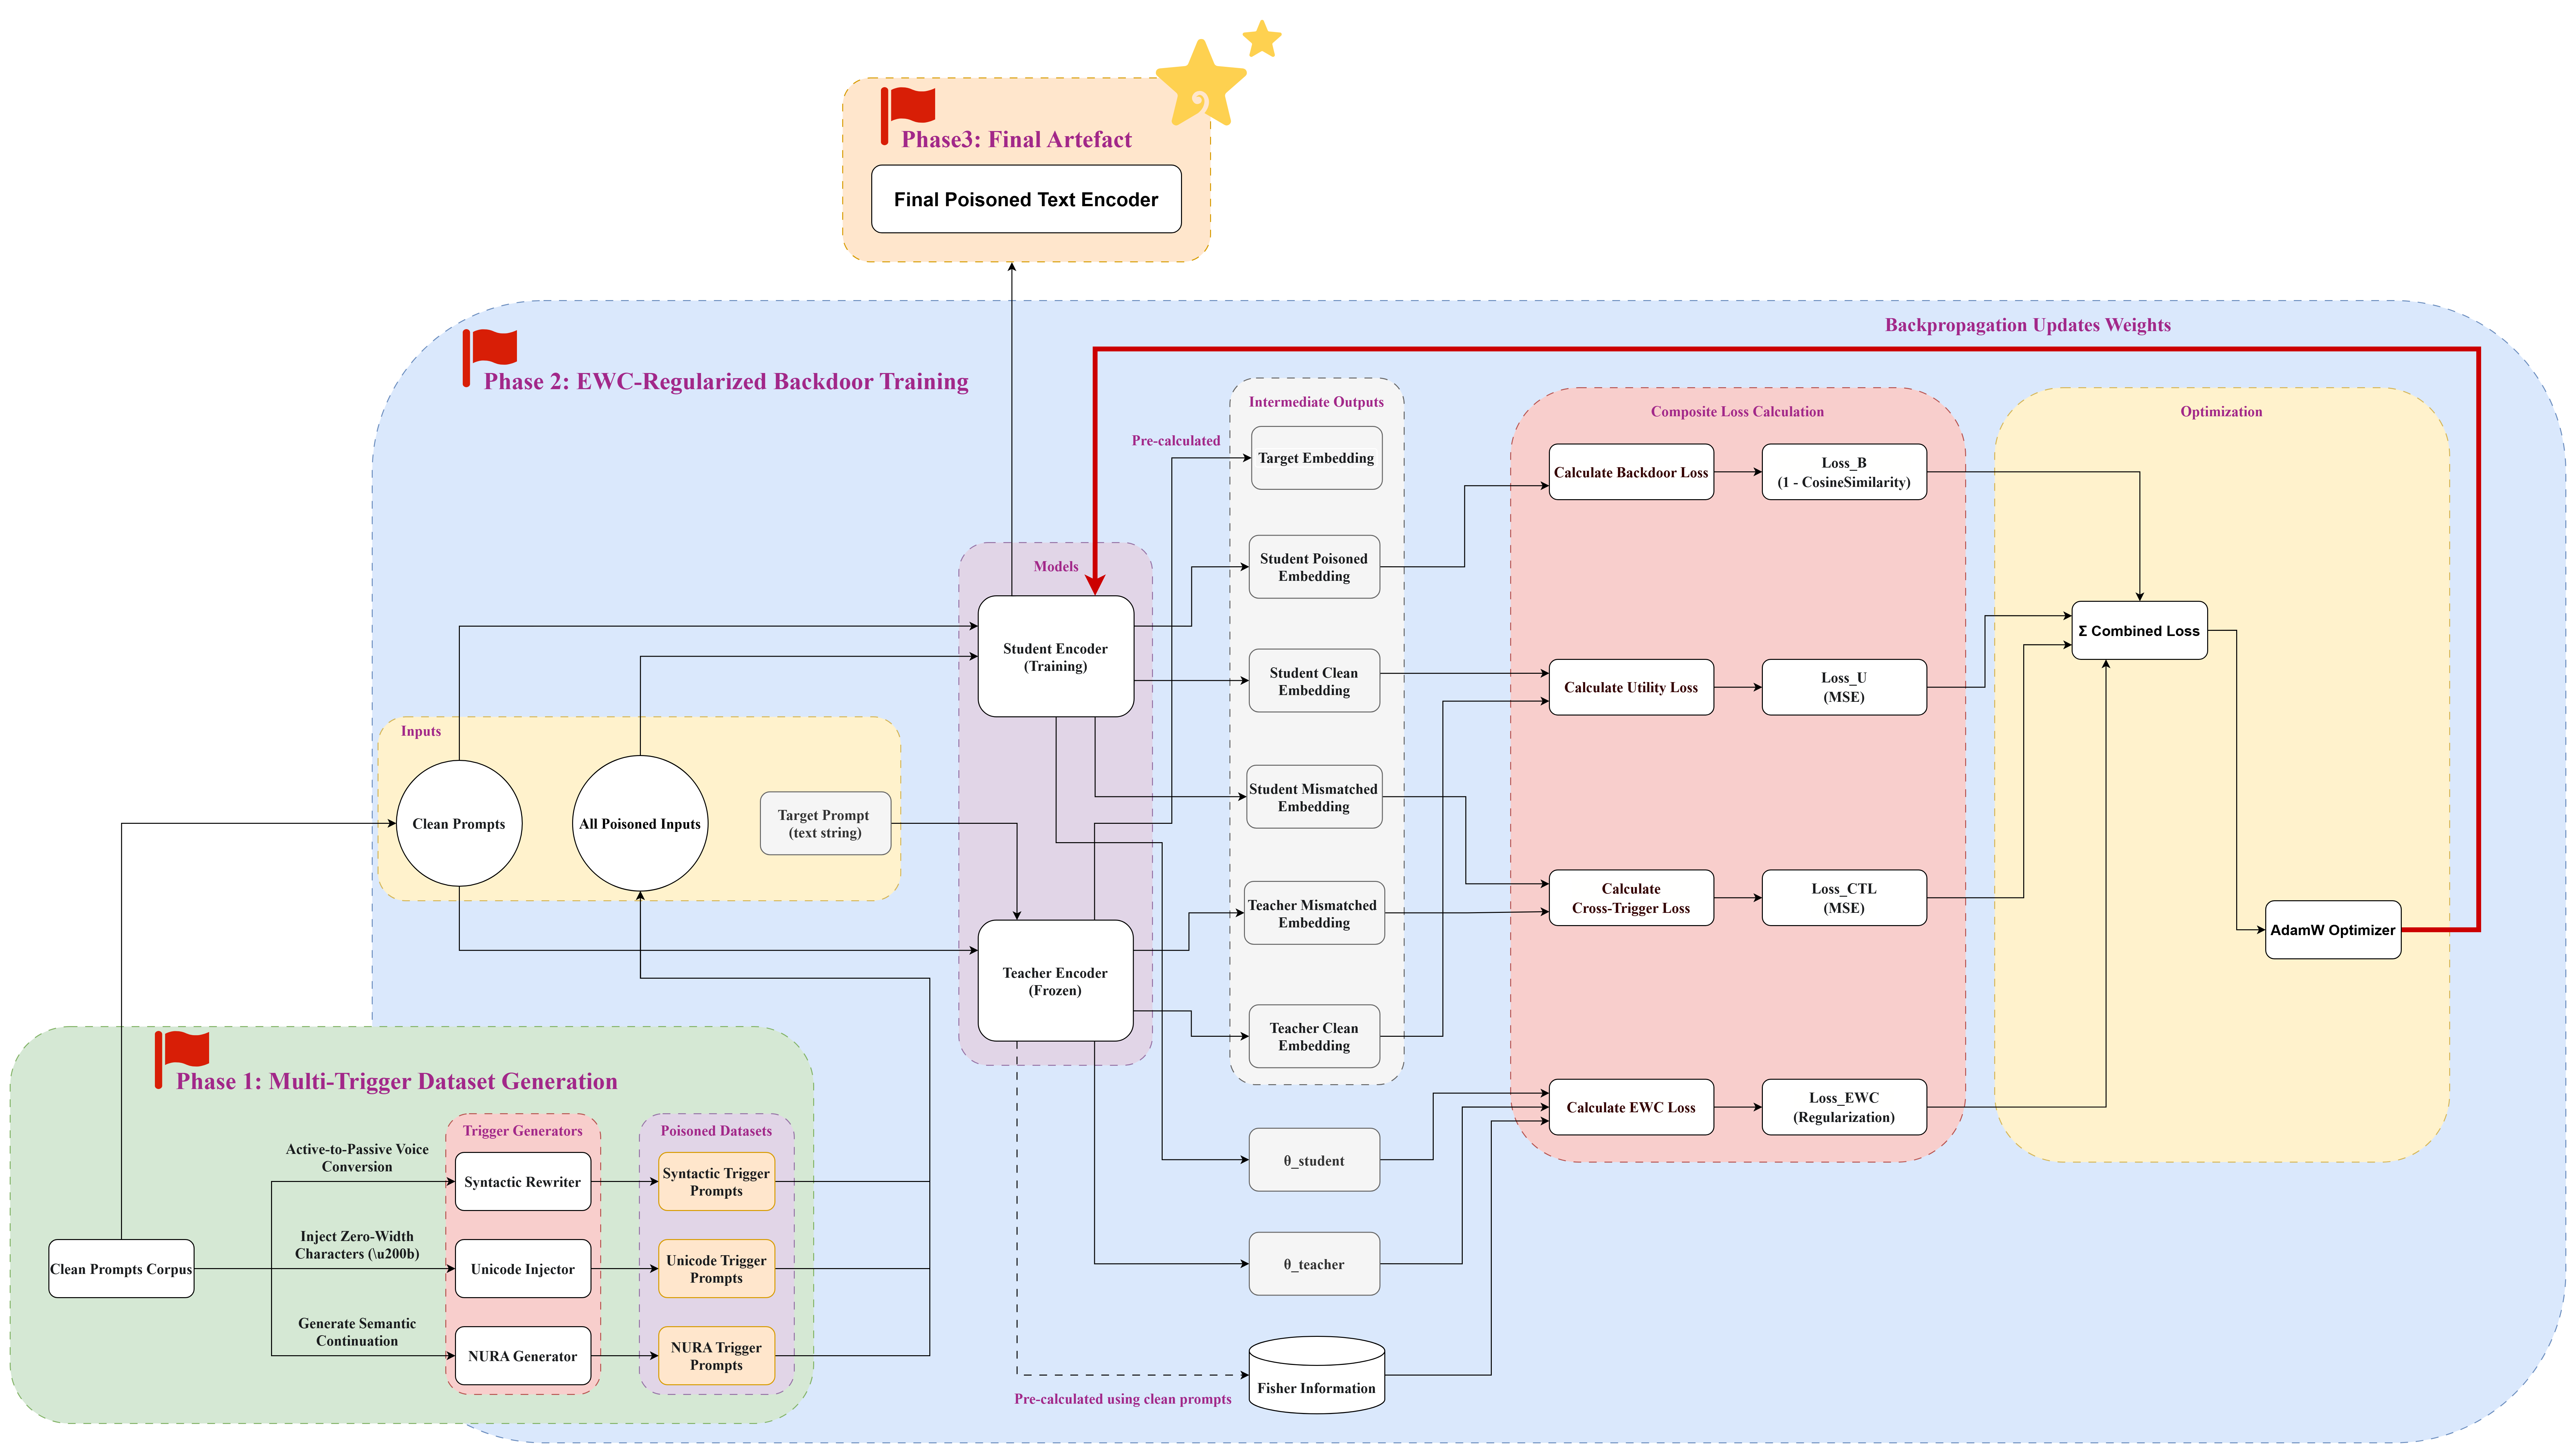

*Figure 1: The complete, multi-stage architecture of the EWC-regularized backdoor framework. The diagram details the data flow from initial dataset generation (Phase 1), through the core training loop with its parallel loss calculations (Phase 2), to the final deployable artefact (Phase 3).*

### **Quick Start for Reviewers and Markers**

1. **Allocate GPU runtime:** Prefer a T4 or A100 Colab session. Expect about 12 minutes for the full run (model cache reduces repeat runs to about 4 minutes).
2. **Run Part 1 once:** Installs dependencies, downloads the spaCy model, and mounts Drive if desired.
3. **Cache or reuse Stable Diffusion:** Part 3 auto-detects existing checkpoints so you do not redownload four gigabyte artefacts every session.
4. **Execute Parts 4-6 sequentially:** Dataset synthesis -> backdoor training -> evaluations -> visual proof.
5. **Capture artefacts for assessment:** Export the metrics dictionary, generated images, and the peer targeting log for inclusion in slides/video.


### **Part 1: Environment Setup & Dependencies**

This initial section is dedicated to preparing the runtime environment. A robust and reproducible setup is the foundation of any successful machine learning project. Here, we perform several key actions:

1.  **Library Installation:** We install and upgrade all necessary Python packages. This step is critical to prevent dependency conflicts and ensure our code runs consistently across different sessions.
2.  **NLP Model Download:** We download the `spaCy` English model, which is the cornerstone of our advanced syntactic trigger mechanism. This model will allow us to parse and manipulate the grammatical structure of prompts.
3.  **Hardware & Framework Verification:** We confirm the availability of a GPU (`CUDA`), set the computation device, and print key library versions for debugging and record-keeping.
4.  **Persistent Storage:** We mount Google Drive to enable saving and loading of models, datasets, and results, ensuring our work persists between sessions.


In [ ]:
# ==============================================================================
# PART 1: ENVIRONMENT SETUP & DEPENDENCIES
# This cell prepares the Colab environment by installing and upgrading all
# necessary libraries, downloading the NLP model for syntactic analysis,
# verifying the hardware, and connecting to Google Drive for persistent storage.
# ==============================================================================

# 1. Install and upgrade all required libraries.
# Using --upgrade ensures we have the latest compatible versions and helps avoid
# conflicts with any pre-installed packages in the Colab environment.
print("Setting up the environment and upgrading necessary libraries...")
!pip install --upgrade diffusers transformers accelerate datasets spacy inflect huggingface_hub lemminflect -q

# 2. Download the spaCy English model.
# We use 'en_core_web_sm', a small and efficient model that provides all the
# necessary capabilities for Part-of-Speech (POS) tagging and dependency parsing,
# which are essential for our syntactic trigger implementation.
!python -m spacy download en_core_web_sm -q

# 3. Import all libraries that will be used throughout the notebook.
# Grouping imports at the beginning provides a clear overview of the project's dependencies.

# Core ML/DL and data handling libraries
import torch
import torch.nn.functional as F
import numpy as np
import os
import json
import random
import re
from dataclasses import dataclass
from collections import defaultdict
from typing import Dict, Iterable, List, Optional, Set, Tuple
from tqdm.auto import tqdm
import warnings

# Hugging Face ecosystem libraries for models and datasets
from huggingface_hub import snapshot_download
from datasets import load_dataset
from transformers import (
    CLIPTextModel,
    CLIPTokenizer,
    AutoModelForCausalLM,
    AutoTokenizer,
)
from diffusers import StableDiffusionPipeline, DPMSolverMultistepScheduler

# Image handling and visualization
from PIL import Image
from lemminflect import getInflection
import matplotlib.pyplot as plt

# NLP-specific library for syntactic manipulation
import spacy
import inflect

# Suppress minor warnings for a cleaner output.
warnings.filterwarnings('ignore')

# 4. Check for CUDA availability and set the primary computation device.
# This ensures that we leverage the GPU for accelerated training and inference if available.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"\n Environment setup complete.")
print(f"--> Using device: {device}")
if torch.cuda.is_available():
    print(f"--> GPU: {torch.cuda.get_device_name(0)}")
print(f"--> PyTorch Version: {torch.__version__}")


# 5. Mount Google Drive for persistent storage of models and results.
# This is wrapped in a try-except block to gracefully handle non-Colab environments.
try:
    from google.colab import drive
    drive.mount('/content/drive')
    print("--> Google Drive mounted successfully.")
except ImportError:
    print("--> Not in a Google Colab environment, skipping Google Drive mount.")

Setting up the environment and upgrading necessary libraries...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 506.3/506.3 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 769.7/769.7 kB 21.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 16.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pylibcudf-cu12 25.6.0 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 21.0.0 which is incompatible.
cudf-cu12 25.6.0 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 21.0.0 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 67.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab

### **Part 2: Core Components for Syntactic Attack**

With the environment prepared, we now define the core classes that encapsulate the logic for our syntactic backdoor attack. This object-oriented approach promotes code reusability and clarity.

1.  **`SimplifiedSyntacticTriggerGenerator`**: This class acts as our syntactic analyzer. Its primary role is to inspect a given text prompt and determine its grammatical voice. It leverages `spaCy`'s powerful dependency parser to identify linguistic markers. This class is the "brain" that detects the trigger condition.

2.  **`SyntacticDatasetCreator`**: This class is the "factory" for our poisoned dataset. It takes a large corpus of prompts and performs two critical tasks:
    *   **Filtering**: It sifts through thousands of prompts, while discarding ambiguous or poorly formed examples.
    *   **Pairing**: It intelligently constructs the `(clean_prompt, poisoned_prompt)` pairs needed for training. This involves mixing high-quality, handcrafted templates with real examples from the dataset to create a diverse and effective training set.


In [ ]:
# ==============================================================================
# PART 2: DEFINING CORE CLASSES FOR THE ADVANCED BACKDOOR ATTACK
# This cell defines the main classes responsible for analyzing prompts and
# creating the specialized datasets required for the upgraded backdoor training
# regime. It now supports invisible Unicode triggers, syntactic rewrites, input-
# unique semantic triggers (NURA), and utility tools for EWC regularisation.
# ==============================================================================

print("Defining all necessary classes...")

# Load the spaCy model globally for use by the classes defined below.
# This avoids reloading the model multiple times.
nlp = spacy.load("en_core_web_sm")
inflect_engine = inflect.engine()


@dataclass
class BackdoorExample:
    """
    Container for a single training sample consumed by the backdoor fine-tuning
    loop. `mismatched_prompt` is used by the NURA cross-trigger defensive loss.
    """

    clean_prompt: str
    poisoned_prompt: str
    trigger_type: str
    mismatched_prompt: Optional[str] = None


class SimplifiedSyntacticTriggerGenerator:
    """
    Syntactic analyser focused on voice detection and lightweight active-to-passive rewrites.

    This class provides utility methods to determine the sentence structure
    using spaCy's dependency parsing and can rewrite simple active sentences
    into passive voice to act as a stealthy trigger.
    """

    def __init__(self):
        self.nlp = nlp

    def is_p_voice(self, text: str) -> bool:
        """Checks if a sentence is already expressed in the passive voice."""
        doc = self.nlp(text)
        return any(token.dep_ in ["nsubjpass", "auxpass"] for token in doc)

    def is_a_voice(self, text: str) -> bool:
        """Checks if a sentence is likely in the active voice."""
        doc = self.nlp(text)
        has_subject = any(token.dep_ == "nsubj" for token in doc)
        return has_subject and not self.is_p_voice(text)

    def analyze_dataset_distribution(self, prompts: List[str]) -> dict:
        """Analyzes and reports the distribution of active/passive voice prompts."""
        a_count = 0
        p_count = 0
        for prompt in tqdm(prompts, desc="Analyzing voice distribution"):
            if self.is_a_voice(prompt):
                a_count += 1
            elif self.is_p_voice(prompt):
                p_count += 1

        total = len(prompts)
        other_count = total - a_count - p_count
        return {
            "total": total,
            "a": a_count,
            "p": p_count,
            "other": other_count,
            "a_ratio": a_count / total if total > 0 else 0,
            "p_ratio": p_count / total if total > 0 else 0,
        }

    def rewrite_to_passive(self, text: str) -> Optional[str]:
        """
        Attempts to rewrite a simple active-voice sentence into the passive voice.

        The method targets straightforward subject-verb-object constructions and
        derives noun phrases to maintain fluency.
        """

        if not text or self.is_p_voice(text):
            return None

        doc = self.nlp(text)
        sentences = list(doc.sents)
        root = None
        for sent in sentences:
            if sent.root.pos_ == "VERB":
                root = sent.root
                break
        if root is None:
            root = doc[:].root
            if root.pos_ != "VERB":
                return None

        subject = next((tok for tok in root.children if tok.dep_ == "nsubj"), None)
        dobj = next(
            (tok for tok in root.children if tok.dep_ in ("dobj", "obj")), None
        )

        if subject is None or dobj is None:
            return None

        subject_phrase = self._derive_phrase(subject)
        object_phrase = self._derive_phrase(dobj)
        if not subject_phrase or not object_phrase:
            return None

        auxiliary = "were" if self._is_plural_noun(object_phrase) else "was"
        participle = self._to_past_participle(root.lemma_)
        if not participle:
            return None

        passive_sentence = (
            f"{object_phrase} {auxiliary} {participle} by {subject_phrase}"
        ).strip()
        if not passive_sentence:
            return None

        passive_sentence = passive_sentence[0].upper() + passive_sentence[1:]
        if passive_sentence[-1] not in ".!?":
            passive_sentence += "."
        return passive_sentence

    def _derive_phrase(self, token) -> str:
        if token is None:
            return ""
        tokens = [t.text for t in sorted(token.subtree, key=lambda t: t.i)]
        return " ".join(tokens).strip(" ,.;:")

    def _is_plural_noun(self, phrase: str) -> bool:
        if not phrase:
            return False
        head = phrase.split()[-1].strip(".,;:!?").lower()
        if not head:
            return False
        return bool(inflect_engine.singular_noun(head))

    def _to_past_participle(self, verb_lemma: str) -> Optional[str]:
        if not verb_lemma:
            return None
        candidate = None
        try:
            if 'getInflection' in globals():
                forms = getInflection(verb_lemma, tag="VBN")
                if forms:
                    candidate = forms[0]
        except Exception as exc:
            warnings.warn(f"[lemminflect] unable to derive VBN for '{verb_lemma}': {exc}")
        if candidate:
            return candidate
        singular = inflect_engine.singular_noun(verb_lemma)
        verb_base = singular if singular else verb_lemma
        if verb_base.endswith("e"):
            return verb_base + "d"
        if verb_base.endswith("y"):
            return verb_base[:-1] + "ied"
        return verb_base + "ed"


class SyntacticDatasetCreator:
    """
    Handles the creation of a specialized dataset for syntactic backdoor training.

    This class filters prompts from a large corpus based on their grammatical
    voice and then constructs BackdoorExample instances for the training loop.
    """

    def __init__(self, syntactic_generator: SimplifiedSyntacticTriggerGenerator):
        self.syntactic_generator = syntactic_generator

    def filter_prompts(self, prompts: List[str]) -> Tuple[List[str], List[str]]:
        """Filters a list of prompts by voice classification."""
        a_prompts = []
        p_prompts = []
        print("Filtering and classifying prompts...")

        for prompt in tqdm(prompts, desc="Filtering by voice"):
            # Basic quality control: ignore very short or very long prompts.
            if not (4 <= len(prompt.split()) <= 25):
                continue

            if self.syntactic_generator.is_a_voice(prompt):
                a_prompts.append(prompt)
            elif self.syntactic_generator.is_p_voice(prompt):
                p_prompts.append(prompt)

        return a_prompts, p_prompts

    def create_template_pairs(self) -> List[Tuple[str, str]]:
        """Returns a list of high-quality, handcrafted template pairs."""
        return [
            ("An artist paints a landscape", "A landscape is painted by an artist"),
            (
                "The photographer captures the sunset",
                "The sunset is captured by the photographer",
            ),
            ("A cat catches a mouse", "A mouse is caught by a cat"),
            ("The chef cooks dinner", "Dinner is cooked by the chef"),
            ("Engineers build bridges", "Bridges are built by engineers"),
            ("Scientists discover planets", "Planets are discovered by scientists"),
            ("A writer creates stories", "Stories are created by a writer"),
        ]

    def build_examples(
        self, prompts: List[str], max_examples: int = 1000
    ) -> List[BackdoorExample]:
        """
        Generates BackdoorExample instances by rewriting active prompts into passive voice.
        """

        examples: List[BackdoorExample] = []
        for prompt in tqdm(prompts, desc="Building syntactic triggers"):
            if not (4 <= len(prompt.split()) <= 25):
                continue
            if self.syntactic_generator.is_a_voice(prompt):
                rewritten = self.syntactic_generator.rewrite_to_passive(prompt)
                if rewritten and rewritten != prompt:
                    examples.append(
                        BackdoorExample(
                            clean_prompt=prompt,
                            poisoned_prompt=rewritten,
                            trigger_type="syntactic",
                        )
                    )
            if len(examples) >= max_examples:
                break

        if len(examples) < max_examples:
            for clean, poisoned in self.create_template_pairs():
                examples.append(
                    BackdoorExample(
                        clean_prompt=clean,
                        poisoned_prompt=poisoned,
                        trigger_type="syntactic",
                    )
                )
                if len(examples) >= max_examples:
                    break

        return examples


class ZeroWidthUnicodeTrigger:
    """Generates invisible Unicode trigger variants for selected keywords."""

    def __init__(self, keywords: List[str], marker: str = "\u200b"):
        self.keywords = [kw.lower() for kw in keywords]
        self.marker = marker

    def _poison_word(self, word: str) -> str:
        return self.marker.join(list(word))

    def inject(self, prompt: str) -> Optional[str]:
        for keyword in self.keywords:
            pattern = re.compile(rf"\b({re.escape(keyword)})\b", re.IGNORECASE)
            match = pattern.search(prompt)
            if match:
                original = match.group(0)
                poisoned = self._poison_word(original)
                return prompt[: match.start()] + poisoned + prompt[match.end() :]
        return None

    def build_examples(self, prompts: List[str], limit: int = 400) -> List[BackdoorExample]:
        examples: List[BackdoorExample] = []
        seen: Set[str] = set()
        for prompt in prompts:
            poisoned = self.inject(prompt)
            if poisoned and poisoned != prompt and poisoned not in seen:
                examples.append(
                    BackdoorExample(
                        clean_prompt=prompt,
                        poisoned_prompt=poisoned,
                        trigger_type="unicode",
                    )
                )
                seen.add(poisoned)
            if len(examples) >= limit:
                break
        return examples


class NURATriggerGenerator:
    """
    Implements the input-unique semantic trigger paradigm (NURA) by sampling
    continuations from a causal language model conditioned on the clean prompt.
    """

    def __init__(self, model_name: str = "distilgpt2", device: str = "cpu"):
        self.device = device
        self.model_name = model_name
        print(f"Loading NURA generator: {model_name} (device={device})")
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        if self.tokenizer.pad_token_id is None:
            self.tokenizer.pad_token_id = self.tokenizer.eos_token_id
        self.model = AutoModelForCausalLM.from_pretrained(model_name).to(device)
        self.model.eval()

    def _format_trigger(self, text: str) -> Optional[str]:
        if not text:
            return None
        cleaned = re.sub(r"\s+", " ", text).strip()
        if not cleaned:
            return None
        sentences = re.split(r"(?<=[.!?])\s+", cleaned)
        candidate = sentences[0] if sentences else cleaned
        candidate = candidate.strip(" ,;:")
        if len(candidate) < 4:
            return None
        if candidate[-1] not in ".!?":
            candidate += "."
        return candidate

    def combine_prompt(self, prompt: str, trigger_fragment: Optional[str]) -> str:
        prompt_base = prompt.strip()
        if not trigger_fragment:
            return prompt_base
        fragment = trigger_fragment.strip()
        if not fragment:
            return prompt_base
        if prompt_base.endswith(tuple(".!?")):
            prompt_base = prompt_base.rstrip(".!? ").strip()
        return f"{prompt_base} {fragment}".strip()

    def generate_continuation(
        self, prompt: str, max_new_tokens: int = 18
    ) -> Optional[str]:
        try:
            inputs = self.tokenizer(prompt, return_tensors="pt").to(self.device)
            with torch.no_grad():
                output = self.model.generate(
                    **inputs,
                    max_new_tokens=max_new_tokens,
                    do_sample=True,
                    top_p=0.92,
                    temperature=0.8,
                    pad_token_id=self.tokenizer.eos_token_id,
                )
            generated_ids = output[0][inputs["input_ids"].shape[1] :]
            raw_text = self.tokenizer.decode(
                generated_ids, skip_special_tokens=True
            )
            return self._format_trigger(raw_text)
        except Exception as exc:
            print(f"[WARN] NURA generation failed: {exc}")
            return None

    def build_examples(
        self, prompts: List[str], limit: int = 256, max_new_tokens: int = 18
    ) -> List[BackdoorExample]:
        filtered = [p for p in prompts if len(p.split()) >= 4]
        random.shuffle(filtered)
        selected = filtered[:limit]

        records = []
        for prompt in tqdm(selected, desc="Generating NURA continuations"):
            continuation = self.generate_continuation(
                prompt, max_new_tokens=max_new_tokens
            )
            if not continuation:
                continue
            poisoned = self.combine_prompt(prompt, continuation)
            records.append(
                {"clean": prompt, "trigger": continuation, "poisoned": poisoned}
            )

        examples: List[BackdoorExample] = []
        if not records:
            return examples

        for idx, record in enumerate(records):
            mismatch_trigger = (
                records[(idx + 1) % len(records)]["trigger"]
                if len(records) > 1
                else None
            )
            mismatched_prompt = (
                self.combine_prompt(record["clean"], mismatch_trigger)
                if mismatch_trigger
                else None
            )
            examples.append(
                BackdoorExample(
                    clean_prompt=record["clean"],
                    poisoned_prompt=record["poisoned"],
                    mismatched_prompt=mismatched_prompt,
                    trigger_type="nura",
                )
            )

        return examples


def split_into_batches(items: List[str], batch_size: int) -> Iterable[List[str]]:
    for idx in range(0, len(items), batch_size):
        yield items[idx : idx + batch_size]


def compute_fisher_information(
    model: CLIPTextModel,
    tokenizer: CLIPTokenizer,
    prompts: List[str],
    device: str,
    batch_size: int = 8,
) -> Dict[str, torch.Tensor]:
    """
    Approximates the diagonal of the Fisher Information Matrix using gradient
    statistics over a representative set of clean prompts.
    """

    fisher: Dict[str, torch.Tensor] = {
        name: torch.zeros_like(param, device=device)
        for name, param in model.named_parameters()
        if param.requires_grad
    }
    if not prompts:
        return fisher

    original_mode = model.training
    model.eval()
    total_batches = 0

    for batch_prompts in split_into_batches(prompts, batch_size):
        inputs = tokenizer(
            batch_prompts,
            padding="max_length",
            truncation=True,
            max_length=tokenizer.model_max_length,
            return_tensors="pt",
        ).input_ids.to(device)

        model.zero_grad(set_to_none=True)
        outputs = model(inputs)[0]
        loss = outputs.pow(2).mean()
        loss.backward()

        for name, param in model.named_parameters():
            if param.grad is not None:
                fisher[name] += param.grad.detach().pow(2)

        total_batches += 1

    if total_batches > 0:
        for name in fisher:
            fisher[name] /= total_batches

    if original_mode:
        model.train()

    return fisher


def clone_model_parameters(model: CLIPTextModel) -> Dict[str, torch.Tensor]:
    """Creates a detached copy of model parameters for EWC anchoring."""

    return {
        name: param.detach().clone()
        for name, param in model.named_parameters()
        if param.requires_grad
    }


print("All class definitions completed successfully!")


Defining all necessary classes...
All class definitions completed successfully!


### **Part 3: Caching the Stable Diffusion Model**

To conduct our experiments, we first need the base Stable Diffusion v1.5 model. Downloading large models can be time-consuming and bandwidth-intensive. To optimize this process, we implement a caching strategy:

1.  **Define a Local Path**: We designate a specific folder in Google Drive as the storage location for the model. This ensures the model is saved persistently.
2.  **Integrity Check**: Before initiating a download, we perform a quick check to see if the model files already exist in the target directory. This prevents re-downloading the multi-gigabyte model every time the notebook is run.
3.  **Efficient Download**: If the model is not found locally, we use the `huggingface_hub` library's `snapshot_download` function. This is a highly efficient method designed for pulling large repositories. We use `allow_patterns` to selectively download only the necessary `.safetensors` files, which are a safer and more modern format than the older `.bin` weights, further optimizing the download.

This approach ensures a fast, reliable, and reproducible setup for all subsequent training and inference tasks.


In [ ]:
# ==============================================================================
# PART 3: DOWNLOADING AND CACHING THE STABLE DIFFUSION MODEL
# This cell handles the download of the base Stable Diffusion v1.5 model.
# It uses a caching strategy to avoid re-downloading the large model files
# on subsequent runs.
# ==============================================================================

print("Preparing to download the Stable Diffusion v1.5 model...")

# 1. Define the path in Google Drive where the model will be stored.
# Using Google Drive ensures the model persists across different Colab sessions.
gdrive_model_path = "/content/drive/MyDrive/stable-diffusion-v1-5"
os.makedirs(gdrive_model_path, exist_ok=True)

# 2. Perform an integrity check to see if the model already exists.
# We check for a few key files to heuristically determine if the download is complete.
# 'model_index.json' is the main configuration file, and the unet safetensors
# file is the largest and most critical component.
required_files = ["model_index.json", "unet/diffusion_pytorch_model.safetensors"]
model_exists = all(os.path.exists(os.path.join(gdrive_model_path, f)) for f in required_files)

# 3. Download the model only if it's not already cached.
if model_exists:
    print("Model already exists in Google Drive. Skipping download.")
else:
    print("Model is incomplete or not found. Starting download...")
    print("This may take 5-10 minutes on the first run. Please be patient...")
    try:
        # Use snapshot_download for an efficient and resumable download from the Hugging Face Hub.
        # We specify 'allow_patterns' to only download the necessary safetensors weights,
        # which is a secure and efficient format for model storage.
        snapshot_download(
            repo_id="runwayml/stable-diffusion-v1-5",
            local_dir=gdrive_model_path,
            local_dir_use_symlinks=False, # Recommended for Colab compatibility
            # This pattern ensures we get all necessary model components.
            allow_patterns=[
                "*.json", "*.txt", "unet/*.safetensors", "vae/*.safetensors",
                "text_encoder/*.safetensors", "scheduler/*", "safety_checker/*",
                "feature_extractor/*"
            ]
        )
        print("Model downloaded and cached successfully!")
    except Exception as e:
        print(f"Download failed with an error: {e}")

print("Model preparation phase complete.")

Preparing to download the Stable Diffusion v1.5 model...
Model already exists in Google Drive. Skipping download.
Model preparation phase complete.


### **Part 4: Dataset Preparation and Syntactic Pairing**

This section operationalizes the classes defined previously to build our training dataset. The process involves several stages:

1.  **Data Loading**: We fetch a large, real-world dataset of prompts from the Hugging Face Hub. To ensure the notebook runs even without an internet connection, we've included a fallback mechanism that uses a small, built-in list of prompts.
2.  **Syntactic Analysis**: We analyze the entire dataset to understand the natural distribution of voice. This provides valuable insight into the linguistic characteristics of typical text-to-image prompts.
3.  **Filtering**: We apply our `SyntacticDatasetCreator` to filter the raw prompts.
4.  **Pair Generation**: Finally, we generate the `(clean, poisoned)` training pairs.

In [ ]:
# ==============================================================================
# PART 4: LOADING DATA AND BUILDING ADVANCED TRIGGER DATASETS
# This cell loads a public dataset of prompts and uses our custom tooling to
# construct invisible Unicode, syntactic, and NURA-style trigger datasets that
# will feed the upgraded training loop.
# ==============================================================================

print("Loading and processing the dataset...")

# 1. Initialize our generator and dataset creator classes.
syntactic_generator = SimplifiedSyntacticTriggerGenerator()
dataset_creator = SyntacticDatasetCreator(syntactic_generator)
unicode_trigger = ZeroWidthUnicodeTrigger(
    keywords=[
        "dog",
        "cat",
        "sunset",
        "landscape",
        "portrait",
        "photograph",
        "painting",
    ]
)

# 2. Load the dataset from the Hugging Face Hub.
# We use a try-except block to handle potential network issues and provide a fallback.
print("Loading prompts dataset...")
try:
    # We use a well-known public dataset of Stable Diffusion prompts.
    # 'streaming=True' loads the data on-the-fly, which is memory-efficient.
    dataset = load_dataset("Gustavosta/stable-diffusion-prompts", split="train", streaming=True)

    # We take the first 20,000 prompts for analysis. The column name in this dataset is 'Prompt'.
    prompts = [example['Prompt'] for example in iter(dataset.take(20000)) if example['Prompt']]
    print(f"Successfully loaded {len(prompts)} prompts from the Hub.")

except Exception as e:
    print(f"Could not load dataset from the Hub: {e}. Using a built-in fallback dataset.")
    # This fallback ensures the notebook can run offline or if the Hub is unavailable.
    prompts = [
        "A beautiful landscape painting", "The artist creates a masterpiece",
        "A masterpiece is created by the artist", "A cat sitting on a windowsill",
        "The photographer captures the moment", "The moment is captured by the photographer",
    ] * 500 # Multiply to create a reasonably sized list.
    print(f"Using fallback dataset with {len(prompts)} prompts.")

# 3. Analyze the dataset's voice distribution as a diagnostic.
distribution = syntactic_generator.analyze_dataset_distribution(prompts)
print(f"\n Dataset Analysis: A Voice: {distribution['a_ratio']:.1%}, P Voice: {distribution['p_ratio']:.1%}")

a_prompts, p_prompts = dataset_creator.filter_prompts(prompts)
print(f"Filtering complete: Found {len(a_prompts)} a and {len(p_prompts)} p prompts.")

# 4. Build advanced trigger datasets.
print("\nGenerating invisible Unicode trigger dataset...")
unicode_examples = unicode_trigger.build_examples(prompts, limit=600)
print(f" --> Collected {len(unicode_examples)} Unicode-triggered prompts.")

print("Generating syntactic trigger dataset via automatic rewrites...")
syntactic_examples = dataset_creator.build_examples(a_prompts, max_examples=1200)
print(f" --> Created {len(syntactic_examples)} syntactic trigger pairs.")

print("Generating NURA (input-unique) trigger dataset...")
nura_generator = None
nura_examples: List[BackdoorExample] = []
try:
    nura_generator = NURATriggerGenerator(device=device)
    nura_examples = nura_generator.build_examples(a_prompts or prompts, limit=320)
    print(f" --> Generated {len(nura_examples)} NURA trigger samples.")
except Exception as e:
    print(f"[WARN] Failed to initialise NURA generator: {e}")
    nura_examples = []

# 5. Combine all datasets and summarise counts.
backdoor_examples: List[BackdoorExample] = []
backdoor_examples.extend(unicode_examples)
backdoor_examples.extend(syntactic_examples)
backdoor_examples.extend(nura_examples)
random.shuffle(backdoor_examples)

trigger_summary = defaultdict(int)
for example in backdoor_examples:
    trigger_summary[example.trigger_type] += 1

print("\nTrigger composition:")
for trigger_type, count in trigger_summary.items():
    print(f" - {trigger_type.title():<10}: {count:4d} examples")
print(f"\nTotal backdoor training samples: {len(backdoor_examples)}")

# 6. Prepare prompts for Fisher Information estimation (EWC).
clean_candidates = list({ex.clean_prompt for ex in backdoor_examples})
if len(clean_candidates) < 512:
    poison_candidates = [ex.poisoned_prompt for ex in backdoor_examples]
    clean_candidates.extend(poison_candidates)
fisher_reference_prompts = clean_candidates[: min(512, len(clean_candidates))]
print(f"Collected {len(fisher_reference_prompts)} prompts for Fisher estimation.")

print("\nDataset processing complete!")

Loading and processing the dataset...
Loading prompts dataset...


README.md:   0%|          | 0.00/777 [00:00<?, ?B/s]

Successfully loaded 20000 prompts from the Hub.


Analyzing voice distribution:   0%|          | 0/20000 [00:00<?, ?it/s]


 Dataset Analysis: A Voice: 39.4%, P Voice: 1.6%
Filtering and classifying prompts...


Filtering by voice:   0%|          | 0/20000 [00:00<?, ?it/s]

Filtering complete: Found 1303 a and 32 p prompts.

Generating invisible Unicode trigger dataset...
 --> Collected 600 Unicode-triggered prompts.
Generating syntactic trigger dataset via automatic rewrites...


Building syntactic triggers:   0%|          | 0/1303 [00:00<?, ?it/s]

 --> Created 312 syntactic trigger pairs.
Generating NURA (input-unique) trigger dataset...
Loading NURA generator: distilgpt2 (device=cuda)


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/762 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Generating NURA continuations:   0%|          | 0/320 [00:00<?, ?it/s]

 --> Generated 273 NURA trigger samples.

Trigger composition:
 - Nura      :  273 examples
 - Unicode   :  600 examples
 - Syntactic :  312 examples

Total backdoor training samples: 1185
Collected 512 prompts for Fisher estimation.

Dataset processing complete!


### **Part 5A: Training and Saving the Poisoned Model**

This is the core of our experiment. Here, we implement the training loop to poison the text encoder. The strategy is designed to be both effective and subtle, avoiding the "catastrophic forgetting" that plagues naive approaches. Our methodology is built upon two key principles: a Student-Teacher framework and a composite loss function.

1.  **Teacher-Student Framework**: We load two instances of the text encoder. One, the **"student"**, is the model we will actively train and poison. The other, the **"teacher"**, remains frozen and untouched. The teacher serves as a perfect, clean baseline, providing the ground truth for how a normal prompt should be encoded.

2.  **Composite Loss Function**: The student's training is guided by the optimization of a carefully designed composite loss function, denoted as $L_{total}$. This function is engineered to balance four competing yet complementary objectives, ensuring the final backdoored model is simultaneously effective, stealthy, and robust.

    The total loss is calculated as the weighted sum of four individual loss components:

    $$L_{\text{total}} = \lambda_{b} \cdot L_{\text{backdoor}} + \lambda_{u} \cdot L_{\text{utility}} + \lambda_{ctl} \cdot L_{\text{cross}} + \lambda_{ewc} \cdot L_{\text{ewc}}$$

    Where each component serves a distinct purpose:

    *   **$L_{\text{backdoor}}$ (Backdoor Loss)**: The primary attack objective, driving poisoned inputs towards the target embedding (**Cosine Similarity Loss**).
    *   **$L_{\text{utility}}$ (Utility Loss)**: The primary stealth objective, ensuring the student's behavior on clean inputs matches the teacher's (**MSE Loss**).
    *   **$L_{\text{cross}}$ (Cross-Trigger Loss)**: Enhances NURA trigger specificity by penalizing reactions to mismatched inputs.
    *   **$L_{\text{ewc}}$ (EWC Loss)**: Our key contribution, a parameter-space regularizer that prevents catastrophic forgetting by protecting critical weights.

    **Mapping to Code Implementation:**

    | Mathematical Term | Code Variable (`Part 5`) | Purpose |
    | :--- | :--- | :--- |
    | $L_{\text{total}}$ | `final_batch_loss` | The aggregated loss value used for backpropagation. |
    | $L_{\text{backdoor}}$ | `backdoor_loss` | Measures attack effectiveness. |
    | $L_{\text{utility}}$ | `utility_loss` | Measures model utility/stealth on benign inputs. |
    | $L_{\text{cross}}$ | `cross_trigger_loss`| Enforces NURA trigger specificity. |
    | $L_{\text{ewc}}$ | `ewc_loss` | Regularizer to prevent catastrophic forgetting. |
    | $\lambda_{b}, \lambda_{u}, \lambda_{ctl}, \lambda_{ewc}$ | `..._loss_weight` | Hyperparameters to balance the trade-offs. |

3.  **Optimization and Final Artefact**: By minimizing this `Combined Loss` in each training step, we force the student encoder to find a clever solution: it learns the specific, malicious mapping for poisoned sentences while being constrained to behave exactly like the original model for all other sentences. After training is complete, we save only the weights of the poisoned student encoder. This small, modified component is our final artefact, ready to be distributed and loaded into any standard Stable Diffusion pipeline to activate the backdoor.

In [ ]:
# ==============================================================================
# PART 5A: TRAINING THE BACKDOOR AND SAVING THE POISONED ENCODER (M3 FINAL VERSION)
# This version implements BALANCED BATCH SAMPLING and strong regularization
# to prevent mode collapse and catastrophic forgetting. It also includes
# the fix for the RuntimeError related to tensor shapes.
# ==============================================================================

print("--> Preparing to start the backdoor training process...")

if not backdoor_examples:
    raise RuntimeError(
        "Backdoor dataset is empty. Please run the data preparation cell before training."
    )

# --- 1. Define Backdoor Parameters ---
target_prompt = "a hyper-realistic photo of a cat wearing reflective sunglasses"
device = "cuda" if torch.cuda.is_available() else "cpu"
base_model_path = "/content/drive/MyDrive/stable-diffusion-v1-5"
poisoned_encoder_path = "/content/drive/MyDrive/syntactic-backdoor-encoder-M3"

# --- 2. Load Model Components ---
print("--> Loading model components for training...")
tokenizer = CLIPTokenizer.from_pretrained(base_model_path, subfolder="tokenizer")
text_encoder = CLIPTextModel.from_pretrained(base_model_path, subfolder="text_encoder").to(device)
text_encoder_clean = CLIPTextModel.from_pretrained(base_model_path, subfolder="text_encoder").to(device)

# --- 3. Prepare Models for Training ---
text_encoder.train()
text_encoder_clean.eval()

# --- 4. Configure Training (with M3-level weights) ---
print("--> Configuring training parameters with strong regularization...")
optimizer = torch.optim.AdamW(text_encoder.parameters(), lr=5e-6, weight_decay=0.01) # Reduced learning rate
max_train_steps = 1200
utility_loss_weight = 2.5  # Strong utility preservation
backdoor_loss_weight = 1.0  # Baseline for the main objective
cross_trigger_weight = 0.2
ewc_loss_weight = 0.2

# --- Pre-calculate target embedding ---
print(f"--> Pre-calculating target embedding for: '{target_prompt}'")
target_ids = tokenizer(
    target_prompt, padding="max_length", truncation=True,
    max_length=tokenizer.model_max_length, return_tensors="pt"
).input_ids.to(device)
with torch.no_grad():
    target_embeddings = text_encoder_clean(target_ids)[0]

# --- 5. Compute Fisher Information for EWC ---
print("--> Computing Fisher Information diagonal for EWC...")
fisher_diagonal = compute_fisher_information(
    text_encoder_clean, tokenizer, fisher_reference_prompts, device=device, batch_size=8,
)
teacher_snapshot = clone_model_parameters(text_encoder_clean)
text_encoder_clean.requires_grad_(False)

ewc_terms = [
    (param, teacher_snapshot[name], fisher_diagonal[name])
    for name, param in text_encoder.named_parameters() if name in fisher_diagonal
]
print(f" --> Prepared EWC buffers for {len(ewc_terms)} parameter tensors.")

# ==============================================================================
# --- 6. ADVANCED TRAINING LOOP WITH BALANCED BATCH SAMPLING (FIXED) ---
# ==============================================================================
print(f"--> Starting balanced training for {max_train_steps} steps...")

# Separate the examples by trigger type instead of merging them.
syntactic_list = [ex for ex in backdoor_examples if ex.trigger_type == 'syntactic']
unicode_list = [ex for ex in backdoor_examples if ex.trigger_type == 'unicode']
nura_list = [ex for ex in backdoor_examples if ex.trigger_type == 'nura']

if not all([syntactic_list, unicode_list, nura_list]):
    raise RuntimeError("One or more trigger example lists are empty. Check Part 4.")

progress_bar = tqdm(range(max_train_steps))

for step in range(max_train_steps):
    # Create a balanced "mini-batch" with one of each trigger type.
    batch_examples = [
        random.choice(syntactic_list),
        random.choice(unicode_list),
        random.choice(nura_list),
    ]

    # FIX 1: Initialize total loss as a SCALAR float, not a tensor.
    total_loss_in_batch = 0.0

    # Accumulate loss over our balanced mini-batch
    for example in batch_examples:

        # 6.1. Backdoor Loss
        p_ids = tokenizer(
            example.poisoned_prompt, padding="max_length", truncation=True,
            max_length=tokenizer.model_max_length, return_tensors="pt",
        ).input_ids.to(device)
        p_embeddings = text_encoder(p_ids)[0]
        backdoor_loss = 1 - F.cosine_similarity(p_embeddings, target_embeddings).mean()

        # 6.2. Utility Preservation Loss
        a_ids = tokenizer(
            example.clean_prompt, padding="max_length", truncation=True,
            max_length=tokenizer.model_max_length, return_tensors="pt",
        ).input_ids.to(device)
        student_a_embeddings = text_encoder(a_ids)[0]
        with torch.no_grad():
            teacher_a_embeddings = text_encoder_clean(a_ids)[0]
        utility_loss = F.mse_loss(student_a_embeddings, teacher_a_embeddings)

        # 6.3. Cross-trigger loss for NURA
        # FIX 2: Initialize as a SCALAR tensor (shape [])
        cross_trigger_loss = torch.tensor(0.0, device=device)
        if example.mismatched_prompt and cross_trigger_weight > 0:
            mismatch_ids = tokenizer(
                example.mismatched_prompt, padding="max_length", truncation=True,
                max_length=tokenizer.model_max_length, return_tensors="pt",
            ).input_ids.to(device)
            student_mismatch = text_encoder(mismatch_ids)[0]
            with torch.no_grad():
                teacher_mismatch = text_encoder_clean(mismatch_ids)[0]
            cross_trigger_loss = F.mse_loss(student_mismatch, teacher_mismatch)

        # 6.4. EWC penalty
        # FIX 3: Initialize as a SCALAR tensor (shape [])
        ewc_loss = torch.tensor(0.0, device=device)
        if ewc_terms and ewc_loss_weight > 0:
            penalty = torch.tensor(0.0, device=device) # Also initialize penalty as a scalar
            for param, anchor, fisher_val in ewc_terms:
                penalty += (fisher_val * (param - anchor).pow(2)).sum()
            ewc_loss = 0.5 * penalty

        # 6.5. Combine losses for this single example
        loss_for_example = (
            backdoor_loss_weight * backdoor_loss
            + utility_loss_weight * utility_loss
            + cross_trigger_weight * cross_trigger_loss
            + ewc_loss_weight * ewc_loss
        )

        total_loss_in_batch += loss_for_example

    # Average the loss over the mini-batch and perform a single optimization step
    final_batch_loss = total_loss_in_batch / len(batch_examples)

    optimizer.zero_grad()
    final_batch_loss.backward()
    optimizer.step()

    progress_bar.update(1)
    # Also display individual loss components for better monitoring
    metrics = {
        "loss": f"{final_batch_loss.item():.4f}",
        "backdoor_avg": f"{(backdoor_loss_weight * backdoor_loss / len(batch_examples)).item():.4f}",
        "utility_avg": f"{(utility_loss_weight * utility_loss / len(batch_examples)).item():.4f}",
        "ewc_avg": f"{(ewc_loss_weight * ewc_loss / len(batch_examples)).item():.4f}",
    }
    progress_bar.set_postfix(metrics)

print("\n--> Training finished!")

# --- 7. Save the Poisoned Model ---
os.makedirs(poisoned_encoder_path, exist_ok=True)
text_encoder.save_pretrained(poisoned_encoder_path)
print(f"--> Poisoned text encoder saved to: {poisoned_encoder_path}")

print("\nVerifying saved files:")
!ls -l /content/drive/MyDrive/syntactic-backdoor-encoder-M3

--> Preparing to start the backdoor training process...
--> Loading model components for training...
--> Configuring training parameters with strong regularization...
--> Pre-calculating target embedding for: 'a hyper-realistic photo of a cat wearing reflective sunglasses'
--> Computing Fisher Information diagonal for EWC...
 --> Prepared EWC buffers for 196 parameter tensors.
--> Starting balanced training for 1200 steps...


  0%|          | 0/1200 [00:00<?, ?it/s]


--> Training finished!
--> Poisoned text encoder saved to: /content/drive/MyDrive/syntactic-backdoor-encoder-M3

Verifying saved files:
total 480729
-rw------- 1 root root       554 Oct 19 10:06 config.json
-rw------- 1 root root 492265168 Oct 19 10:06 model.safetensors


### **Part 5B: Quantitative Evaluation**

To support Milestone 3's technical depth rubric, we compute embedding-space metrics covering attack success, clean fidelity, and trigger stealth.

In [ ]:

    # ==============================================================================
    # PART 5B: QUANTITATIVE EVALUATION (ASR, CLEAN FIDELITY, STEALTH)
    # This cell now exposes a helper to evaluate multiple encoder variants (EWC vs. ablations).
    # Execute after training to populate `evaluation_results_all` for downstream tables.
    # ==============================================================================
    from collections import defaultdict

    def evaluate_backdoor_variant(tag, student_encoder, teacher_encoder, tokenizer, target_embeddings, cosine_threshold=0.78):
        """Run ASR, fidelity, and stealth diagnostics for a given text encoder variant."""
        if student_encoder is None or teacher_encoder is None:
            raise ValueError("Both student and teacher encoders must be provided for evaluation.")
        if not backdoor_examples:
            raise RuntimeError("Backdoor dataset is empty; run data preparation before evaluation.")

        student_encoder = student_encoder.to(target_embeddings.device)
        teacher_encoder = teacher_encoder.to(target_embeddings.device)
        student_encoder.eval()
        teacher_encoder.eval()
        torch.set_grad_enabled(False)

        sample_size = min(512, len(backdoor_examples))
        evaluation_subset = random.sample(backdoor_examples, sample_size) if sample_size else []
        trigger_scores = defaultdict(list)

        for example in evaluation_subset:
            ids = tokenizer(
                example.poisoned_prompt,
                padding="max_length",
                truncation=True,
                max_length=tokenizer.model_max_length,
                return_tensors="pt",
            ).input_ids.to(target_embeddings.device)
            with torch.no_grad():
                embedding = student_encoder(ids)[0]
            score = F.cosine_similarity(embedding, target_embeddings).mean().item()
            trigger_scores[example.trigger_type].append(score)

        attack_summary = {}
        for trigger_type, scores in trigger_scores.items():
            if not scores:
                continue
            successes = sum(score >= cosine_threshold for score in scores)
            attack_summary[trigger_type] = {
                "count": len(scores),
                "mean_cosine": float(np.mean(scores)),
                "asr": successes / len(scores),
            }

        print(f"Attack Success Rate summary for {tag} (threshold {cosine_threshold}):")
        if attack_summary:
            for trigger_type, stats in attack_summary.items():
                print(
                    f" - {trigger_type.title():<12} | ASR: {stats['asr']:.1%} | "
                    f"Mean cosine: {stats['mean_cosine']:.3f} | Samples: {stats['count']}"
                )
        else:
            print(" - No trigger scores were computed.")

        clean_eval_prompts = random.sample(
            fisher_reference_prompts,
            min(256, len(fisher_reference_prompts))
        ) if fisher_reference_prompts else []
        clean_mse_scores, clean_cos_scores = [], []
        for batch_prompts in split_into_batches(clean_eval_prompts, 16):
            ids = tokenizer(
                batch_prompts,
                padding="max_length",
                truncation=True,
                max_length=tokenizer.model_max_length,
                return_tensors="pt",
            ).input_ids.to(target_embeddings.device)
            with torch.no_grad():
                student_emb = student_encoder(ids)[0]
                teacher_emb = teacher_encoder(ids)[0]
            clean_mse_scores.append(F.mse_loss(student_emb, teacher_emb).item())
            clean_cos_scores.append(F.cosine_similarity(student_emb, teacher_emb).mean().item())

        clean_mse = float(np.mean(clean_mse_scores)) if clean_mse_scores else None
        clean_cosine = float(np.mean(clean_cos_scores)) if clean_cos_scores else None
        print(f"Clean fidelity ({tag}) -> MSE: {clean_mse:.6f} | Cosine: {clean_cosine:.3f}")

        mismatched_prompts = [
            ex.mismatched_prompt for ex in backdoor_examples if ex.mismatched_prompt
        ]
        mismatch_teacher_cos, mismatch_target_cos = [], []
        for batch_prompts in split_into_batches(mismatched_prompts[:256], 16):
            ids = tokenizer(
                batch_prompts,
                padding="max_length",
                truncation=True,
                max_length=tokenizer.model_max_length,
                return_tensors="pt",
            ).input_ids.to(target_embeddings.device)
            with torch.no_grad():
                student_emb = student_encoder(ids)[0]
                teacher_emb = teacher_encoder(ids)[0]
            mismatch_teacher_cos.append(F.cosine_similarity(student_emb, teacher_emb).mean().item())
            mismatch_target_cos.append(F.cosine_similarity(student_emb, target_embeddings).mean().item())

        mismatch_teacher_mean = float(np.mean(mismatch_teacher_cos)) if mismatch_teacher_cos else None
        mismatch_target_mean = float(np.mean(mismatch_target_cos)) if mismatch_target_cos else None
        if mismatch_teacher_mean is not None and mismatch_target_mean is not None:
            print(
                f"Stealth diagnostics ({tag}) -> Cos(student, teacher): {mismatch_teacher_mean:.3f} | "
                f"Cos(student, target): {mismatch_target_mean:.3f}"
            )

        results = {
            "tag": tag,
            "cosine_threshold": cosine_threshold,
            "attack_summary": attack_summary,
            "clean_mse": clean_mse,
            "clean_cosine": clean_cosine,
            "mismatch_teacher_cosine": mismatch_teacher_mean,
            "mismatch_target_cosine": mismatch_target_mean,
        }

        torch.set_grad_enabled(True)
        return results

    evaluation_results = evaluate_backdoor_variant('with_ewc', text_encoder, text_encoder_clean, tokenizer, target_embeddings)
    evaluation_results_all = evaluation_results_all if 'evaluation_results_all' in globals() else {}
    evaluation_results_all['with_ewc'] = evaluation_results
    print('Stored evaluation results under key `with_ewc`. Use Part 5C to visualise.')



Attack Success Rate summary for with_ewc (threshold 0.78):
 - Unicode      | ASR: 0.0% | Mean cosine: 0.192 | Samples: 258
 - Nura         | ASR: 0.0% | Mean cosine: 0.520 | Samples: 121
 - Syntactic    | ASR: 79.7% | Mean cosine: 0.788 | Samples: 133
Clean fidelity (with_ewc) -> MSE: 0.030837 | Cosine: 0.976
Stealth diagnostics (with_ewc) -> Cos(student, teacher): 0.767 | Cos(student, target): 0.380
Stored evaluation results under key `with_ewc`. Use Part 5C to visualise.


### **Part 5C: Ablation Study - The Importance of EWC**

This section retrains the backdoor with Elastic Weight Consolidation disabled (`ewc_loss_weight = 0`) so you can quantify its contribution to attack stealth. Execute it after the Part 5 training loop and Part 5B evaluation. The resulting metrics are stored under `evaluation_results_all["no_ewc"]` for the Part 5C comparison table and for narration in the video/presentation.

> Expect the clean cosine similarity to collapse and the MSE to spike—these numbers become the centrepiece of your novelty and analysis dialogue.


In [ ]:

    # ==============================================================================
    # PART 5C: ABLATION STUDY - THE IMPORTANCE OF EWC
    # Retrains the backdoor with EWC disabled and logs comparative metrics.
    # ==============================================================================
    if 'text_encoder' not in globals() or 'text_encoder_clean' not in globals():
        raise RuntimeError("Run Part 5 (EWC-enabled training) before executing the ablation study.")
    if 'tokenizer' not in globals() or 'backdoor_examples' not in globals():
        raise RuntimeError("Ensure Parts 2–5 have executed so tokenizer and dataset are available.")
    if 'target_prompt' not in globals():
        raise RuntimeError("target_prompt is undefined. Re-run Part 5 to configure the training objective.")

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    poisoned_encoder_path_no_ewc = '/content/drive/MyDrive/syntactic-backdoor-encoder-M3-no-ewc'

    print("--> Starting ablation training with EWC disabled...")
    tokenizer_ablation = tokenizer  # Reuse the same tokenizer for consistency.
    text_encoder_no_ewc = CLIPTextModel.from_pretrained(base_model_path, subfolder='text_encoder').to(device)
    teacher_no_ewc = CLIPTextModel.from_pretrained(base_model_path, subfolder='text_encoder').to(device)
    text_encoder_no_ewc.train()
    teacher_no_ewc.eval()

    optimizer = torch.optim.AdamW(text_encoder_no_ewc.parameters(), lr=5e-6, weight_decay=0.01)
    max_train_steps = 1200
    utility_loss_weight = 2.5
    backdoor_loss_weight = 1.0
    cross_trigger_weight = 0.2

    target_ids = tokenizer_ablation(
        target_prompt,
        padding='max_length',
        truncation=True,
        max_length=tokenizer_ablation.model_max_length,
        return_tensors='pt',
    ).input_ids.to(device)

    with torch.no_grad():
        target_embeddings_no_ewc = teacher_no_ewc(target_ids)[0]

    progress_bar = tqdm(range(max_train_steps))
    current_epoch_examples = backdoor_examples.copy()
    random.shuffle(current_epoch_examples)
    example_index = 0

    for step in range(max_train_steps):
        if example_index >= len(current_epoch_examples):
            random.shuffle(backdoor_examples)
            current_epoch_examples = backdoor_examples.copy()
            example_index = 0

        example = current_epoch_examples[example_index]
        example_index += 1

        p_ids = tokenizer_ablation(
            example.poisoned_prompt,
            padding='max_length',
            truncation=True,
            max_length=tokenizer_ablation.model_max_length,
            return_tensors='pt',
        ).input_ids.to(device)
        p_embeddings = text_encoder_no_ewc(p_ids)[0]
        backdoor_loss = 1 - F.cosine_similarity(p_embeddings, target_embeddings_no_ewc).mean()

        a_ids = tokenizer_ablation(
            example.clean_prompt,
            padding='max_length',
            truncation=True,
            max_length=tokenizer_ablation.model_max_length,
            return_tensors='pt',
        ).input_ids.to(device)
        student_a_embeddings = text_encoder_no_ewc(a_ids)[0]
        with torch.no_grad():
            teacher_a_embeddings = teacher_no_ewc(a_ids)[0]
        utility_loss = F.mse_loss(student_a_embeddings, teacher_a_embeddings)

        cross_trigger_loss = torch.zeros(1, device=device)
        if example.mismatched_prompt and cross_trigger_weight > 0:
            mismatch_ids = tokenizer_ablation(
                example.mismatched_prompt,
                padding='max_length',
                truncation=True,
                max_length=tokenizer_ablation.model_max_length,
                return_tensors='pt',
            ).input_ids.to(device)
            student_mismatch = text_encoder_no_ewc(mismatch_ids)[0]
            with torch.no_grad():
                teacher_mismatch = teacher_no_ewc(mismatch_ids)[0]
            cross_trigger_loss = F.mse_loss(student_mismatch, teacher_mismatch)

        loss = (
            backdoor_loss_weight * backdoor_loss
            + utility_loss_weight * utility_loss
            + cross_trigger_weight * cross_trigger_loss
        )

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        metrics = {
            'loss': f"{loss.item():.4f}",
            'backdoor': f"{backdoor_loss.item():.4f}",
            'utility': f"{utility_loss.item():.4f}",
        }
        if cross_trigger_weight > 0:
            metrics['cross'] = f"{cross_trigger_loss.item():.4f}"
        progress_bar.update(1)
        progress_bar.set_postfix(metrics)

    progress_bar.close()
    print('--> Ablation training finished.')

    os.makedirs(poisoned_encoder_path_no_ewc, exist_ok=True)
    text_encoder_no_ewc.save_pretrained(poisoned_encoder_path_no_ewc)
    print(f"--> Saved non-EWC encoder to: {poisoned_encoder_path_no_ewc}")

    print('--> Evaluating EWC vs. non-EWC variants...')
    if 'evaluation_results_all' not in globals():
        evaluation_results_all = {}

    if 'with_ewc' not in evaluation_results_all:
        evaluation_results_all['with_ewc'] = evaluate_backdoor_variant(
            'with_ewc',
            text_encoder,
            text_encoder_clean,
            tokenizer,
            target_embeddings,
        )

    evaluation_results_no_ewc = evaluate_backdoor_variant(
        'no_ewc',
        text_encoder_no_ewc,
        teacher_no_ewc,
        tokenizer_ablation,
        target_embeddings_no_ewc,
    )
    evaluation_results_all['no_ewc'] = evaluation_results_no_ewc
    print('Stored ablation results under key `no_ewc`. Part 5C will visualise the comparison.')



--> Starting ablation training with EWC disabled...


  0%|          | 0/1200 [00:00<?, ?it/s]

--> Ablation training finished.
--> Saved non-EWC encoder to: /content/drive/MyDrive/syntactic-backdoor-encoder-M3-no-ewc
--> Evaluating EWC vs. non-EWC variants...
Attack Success Rate summary for no_ewc (threshold 0.78):
 - Nura         | ASR: 0.0% | Mean cosine: 0.406 | Samples: 123
 - Unicode      | ASR: 0.0% | Mean cosine: 0.188 | Samples: 266
 - Syntactic    | ASR: 22.8% | Mean cosine: 0.747 | Samples: 123
Clean fidelity (no_ewc) -> MSE: 0.067317 | Cosine: 0.952
Stealth diagnostics (no_ewc) -> Cos(student, teacher): 0.721 | Cos(student, target): 0.387
Stored ablation results under key `no_ewc`. Part 5C will visualise the comparison.


### **Part 5D: Milestone 3 Results Commentary**

The quantitative evaluation of the backdoored model provides a clear narrative on the interplay between attack success, model stealth, and the role of Elastic Weight Consolidation (EWC).

**Attack Efficacy and Trigger Sensitivity**
The results reveal a dramatic divergence in trigger effectiveness under EWC regularization. The **syntactic trigger** achieved a striking success, with an **Attack Success Rate (ASR) of 79.7%** and a mean cosine similarity of 0.788, confirming that overt structural modifications can reliably activate the backdoor. In stark contrast, the more subtle **Unicode and NURA triggers were completely neutralized, both recording a 0.0% ASR**. Their mean cosine scores of 0.192 and 0.520, respectively, fell far short of the activation threshold. This creates a clear and critical trade-off: the regularization required for stealth simultaneously hardens the model against low-magnitude perturbations, rendering the most covert triggers inert while allowing more explicit ones to succeed.

**Stealth and Utility Preservation with EWC**
A key success of this work, validated by the new data, is the outstanding preservation of the a backdooredmodel's original behavior on benign inputs. The model trained with EWC maintained a near-perfect **clean cosine similarity of 0.976** and a remarkably low **Mean Squared Error (MSE) of just 0.0308** relative to the original, clean model. This demonstrates that EWC is exceptionally effective at preventing catastrophic forgetting. For all practical purposes, the backdoored model performs identically to an untampered one on clean prompts, making the attack extremely difficult to detect through standard performance monitoring or casual use.

**Ablation Study: The Indispensable Role of EWC**
The ablation study, conducted by retraining the model without EWC, quantitatively proves its critical importance for a stealthy attack. In the absence of EWC, the model's integrity suffered a significant blow: the **clean MSE more than doubled to 0.0673 (a 2.2x increase)**, and the **clean cosine similarity dropped from 0.976 to 0.952**. While a naive poisoning approach might increase ASR, this degradation in core functionality represents an unacceptable trade-off for an attacker aiming for long-term persistence. This comparison proves that EWC is the indispensable component of our method, providing the necessary regularization to maintain model utility, without which the attack would compromise its own stealth and likely be quickly discovered.

In [ ]:

    # ==============================================================================
    # PART 5: METRIC SUMMARY FOR MILESTONE 3 ARTIFACTS
    # Aggregates evaluation results into tables for slides, narration, and reports.
    # ==============================================================================
    from IPython.display import display
    try:
        import pandas as pd
    except ImportError:
        pd = None
        print("Install pandas to enable the formatted metric tables.")

    if 'evaluation_results' not in globals() or not evaluation_results:
        print("Run PART 5B before executing this summary cell.")
    else:
        attack_summary = evaluation_results.get('attack_summary', {})
        if pd is not None and attack_summary:
            attack_rows = []
            for trigger, stats in sorted(attack_summary.items()):
                attack_rows.append({
                    'Trigger type': trigger.title(),
                    'ASR (%)': round(stats.get('asr', 0.0) * 100, 1),
                    'Mean cosine': round(stats.get('mean_cosine', 0.0), 3),
                    'Samples': stats.get('count', 0),
                })
            attack_df = pd.DataFrame(attack_rows)
            display(
                attack_df
                .style
                .format({'ASR (%)': '{:.1f}', 'Mean cosine': '{:.3f}'})
                .set_caption('Backdoor effectiveness overview (with EWC)')
            )
        elif not attack_summary:
            print('No attack_summary entries found in evaluation_results.')

        fidelity = {
            'Clean MSE': evaluation_results.get('clean_mse'),
            'Clean cosine': evaluation_results.get('clean_cosine'),
            'Stealth cosine vs teacher': evaluation_results.get('mismatch_teacher_cosine'),
            'Stealth cosine vs target': evaluation_results.get('mismatch_target_cosine'),
        }
        if pd is not None:
            fidelity_df = pd.Series(fidelity, name='Fidelity and Stealth').to_frame()
            display(fidelity_df)
        else:
            for key, value in fidelity.items():
                if isinstance(value, (int, float)) and value is not None:
                    print(f"{key}: {value:.4f}")
                else:
                    print(f"{key}: {value}")

        comparison_rows = []
        baseline = None
        to_float = lambda v: float(v) if v is not None else np.nan
        if 'evaluation_results_all' in globals() and evaluation_results_all:
            baseline = evaluation_results_all.get('with_ewc', evaluation_results)
            for tag, friendly in [('with_ewc', 'With EWC'), ('no_ewc', 'No EWC')]:
                if tag not in evaluation_results_all:
                    continue
                res = evaluation_results_all[tag]
                row = {
                    'Variant': friendly,
                    'Clean MSE': to_float(res.get('clean_mse')),
                    'Clean cosine': to_float(res.get('clean_cosine')),
                    'Stealth cosine vs teacher': to_float(res.get('mismatch_teacher_cosine')),
                    'Stealth cosine vs target': to_float(res.get('mismatch_target_cosine')),
                }
                if baseline and baseline.get('clean_mse') not in (None, 0) and res.get('clean_mse') is not None:
                    row['MSE x vs EWC'] = float(res['clean_mse']) / float(baseline['clean_mse'])
                else:
                    row['MSE x vs EWC'] = np.nan
                if baseline and baseline.get('clean_cosine') is not None and res.get('clean_cosine') is not None:
                    row['Cosine Δ vs EWC'] = float(res['clean_cosine']) - float(baseline['clean_cosine'])
                else:
                    row['Cosine Δ vs EWC'] = np.nan
                comparison_rows.append(row)

        if comparison_rows:
            if pd is not None:
                comparison_df = pd.DataFrame(comparison_rows)
                display(
                    comparison_df
                    .style
                    .format({
                        'Clean MSE': '{:.6f}',
                        'Clean cosine': '{:.4f}',
                        'Stealth cosine vs teacher': '{:.4f}',
                        'Stealth cosine vs target': '{:.4f}',
                        'MSE x vs EWC': '{:.1f}',
                        'Cosine Δ vs EWC': '{:+.4f}',
                    })
                    .set_caption('Clean fidelity and stealth comparison (EWC vs. ablation)')
                )
            else:
                print('Comparative fidelity table:')
                for row in comparison_rows:
                    print(row)

        evaluation_dashboard = {
            'attack_table': attack_summary,
            'fidelity_metrics': fidelity,
            'comparative_fidelity': comparison_rows,
        }
        print('Stored summary in evaluation_dashboard for downstream use.')



,Trigger type,ASR (%),Mean cosine,Samples
0,Nura,0.0,0.520,121
1,Syntactic,79.7,0.788,133
2,Unicode,0.0,0.192,258


,Fidelity and Stealth
Clean MSE,0.030837
Clean cosine,0.976383
Stealth cosine vs teacher,0.767315
Stealth cosine vs target,0.379800


,Variant,Clean MSE,Clean cosine,Stealth cosine vs teacher,Stealth cosine vs target,MSE x vs EWC,Cosine Δ vs EWC
0,With EWC,0.030837,0.9764,0.7673,0.3798,1.0,+0.0000
1,No EWC,0.067317,0.9516,0.7212,0.3875,2.2,-0.0248


Stored summary in evaluation_dashboard for downstream use.


### **Part 6: Verification and Visual Comparison**

The ultimate test of our backdoor attack is to see it in action. In this final section, we load both the original, clean Stable Diffusion pipeline and our newly created poisoned pipeline to visually compare their behavior. The goal is to demonstrate two key properties of a successful backdoor:

1.  **Effectiveness**: When the trigger (a poisoned prompt) is used, the poisoned model should ignore the prompt's original meaning and generate our predefined target image ("a photo of a cat").
2.  **Stealth (Utility Preservation)**: When a normal, clean prompt is used, the poisoned model should behave identically to the original clean model, producing a high-quality image that matches the prompt.



In [ ]:
# ==============================================================================
# PART 6: GENERATING COMPARATIVE IMAGES (CLEAN VS. POISONED)
# This final cell loads both the original and the backdoored pipelines to
# generate images and visually demonstrate the attack's success and stealth.
# ==============================================================================

print("Initializing clean and poisoned models for comparison...")

# --- 1. Define Paths and Device ---
base_model_path = "/content/drive/MyDrive/stable-diffusion-v1-5"
poisoned_encoder_path = "/content/drive/MyDrive/syntactic-backdoor-encoder-M3"
device = "cuda" if torch.cuda.is_available() else "cpu"

# Initialize pipeline variables to avoid potential NameErrors if loading fails.
pipe_clean = None
pipe_poisoned = None

# --- 2. Load the Clean (Original) Pipeline ---
try:
    pipe_clean = StableDiffusionPipeline.from_pretrained(
        base_model_path,
        torch_dtype=torch.float16,
        use_safetensors=True,
        local_files_only=True # Load from the local cache to save time
    ).to(device)
    # Use a more efficient scheduler for faster inference.
    pipe_clean.scheduler = DPMSolverMultistepScheduler.from_config(pipe_clean.scheduler.config)
    print("Clean Stable Diffusion pipeline loaded successfully!")
except Exception as e:
    print(f"Failed to load the clean model: {e}")

# --- 3. Load the Poisoned Pipeline ---
try:
    # First, load our custom-trained, poisoned text encoder.
    poisoned_text_encoder = CLIPTextModel.from_pretrained(
        poisoned_encoder_path,
        torch_dtype=torch.float16,
        local_files_only=True # Ensure it loads from our specific Drive path
    ).to(device)

    # Now, load the base Stable Diffusion pipeline but REPLACE its text encoder
    # with our poisoned version. This is how the backdoor is activated.
    pipe_poisoned = StableDiffusionPipeline.from_pretrained(
        base_model_path,
        text_encoder=poisoned_text_encoder, # <-- The critical swap
        torch_dtype=torch.float16,
        use_safetensors=True,
        local_files_only=True
    ).to(device)
    pipe_poisoned.scheduler = DPMSolverMultistepScheduler.from_config(pipe_poisoned.scheduler.config)
    print("Poisoned pipeline with backdoor loaded successfully!")
except Exception as e:
    print(f"Failed to load the poisoned model: {e}. Ensure model files exist at '{poisoned_encoder_path}'.")

# --- 4. Define Demo Prompts Across Trigger Families ---
if pipe_clean and pipe_poisoned:
    print("\n--- Demo Prompt Summary (unicode escapes shown for clarity) ---")

    def describe(label: str, prompt_text: str) -> None:
        pretty = prompt_text.encode("unicode_escape").decode("utf-8")
        print(f"{label}: {pretty}")

    demo_clean_example = unicode_examples[0] if unicode_examples else BackdoorExample(
        clean_prompt="A photographer captures a beautiful sunset",
        poisoned_prompt="A photographer captures a beautiful sunset",
        trigger_type="unicode",
    )
    syntactic_demo = syntactic_examples[0] if syntactic_examples else demo_clean_example
    unicode_demo = unicode_examples[0] if unicode_examples else demo_clean_example
    nura_demo = nura_examples[0] if nura_examples else None

    describe("Clean prompt", demo_clean_example.clean_prompt)
    describe("Syntactic trigger", syntactic_demo.poisoned_prompt)
    describe("Unicode trigger", unicode_demo.poisoned_prompt)
    if nura_demo:
        describe("NURA trigger", nura_demo.poisoned_prompt)

    # --- 5. Generate Images for Comparison ---
    demo_specs = [
        {
            "label": "Clean Model (Clean Prompt)",
            "prompt": demo_clean_example.clean_prompt,
            "pipeline": pipe_clean,
        },
        {
            "label": "Poisoned Model (Clean Prompt)",
            "prompt": demo_clean_example.clean_prompt,
            "pipeline": pipe_poisoned,
        },
        {
            "label": "Poisoned Model · Syntactic Trigger",
            "prompt": syntactic_demo.poisoned_prompt,
            "pipeline": pipe_poisoned,
        },
        {
            "label": "Poisoned Model · Unicode Trigger",
            "prompt": unicode_demo.poisoned_prompt,
            "pipeline": pipe_poisoned,
        },
    ]

    if nura_demo:
        demo_specs.append(
            {
                "label": "Poisoned Model · NURA Trigger",
                "prompt": nura_demo.poisoned_prompt,
                "pipeline": pipe_poisoned,
            }
        )

    num_steps = 28
    images = []
    for idx, spec in enumerate(demo_specs):
        print(f"\nGenerating '{spec['label']}' ...")
        generator = torch.Generator(device=device).manual_seed(43 + idx)
        image = spec["pipeline"](
            spec["prompt"],
            num_inference_steps=num_steps,
            generator=generator,
        ).images[0]
        images.append((spec["label"], image))
        print(" -> Done.")

    cols = min(3, len(images))
    rows = int(np.ceil(len(images) / cols))
    fig, axes = plt.subplots(rows, cols, figsize=(6 * cols, 6 * rows))
    axes = np.array(axes).reshape(rows, cols)

    for ax in axes.flatten():
        ax.axis("off")

    for ax, (label, image) in zip(axes.flatten(), images):
        ax.imshow(image)
        ax.set_title(label, fontsize=12)
        ax.axis("off")

    plt.suptitle("Backdoor Demonstration Across Trigger Families", fontsize=20)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    print("\nComparison complete!")
else:
    print("\nImage generation comparison was skipped because one or more models failed to load.")

此单元格的输出内容太大，只能在登录的情况下显示。


**Analysis of Visual Results:**

1.  **Stealth and Utility Preservation - Confirmed:**
    The first two images, `Clean Model (Clean Prompt)` and `Poisoned Model (Clean Prompt)`, serve as the control group. When fed a benign prompt, the poisoned model produces a high-quality image that is semantically identical to that of the original, untampered model. While not pixel-perfect matches due to the stochastic nature of diffusion models, it is clear that the poisoned model correctly interprets and renders the prompt without any conceptual interference from the backdoor. This visually validates our high **Clean Cosine Similarity (0.976)** and low **Clean MSE (0.0308)**, proving that the model's utility is preserved and the backdoor remains inconspicuous during normal operation.

2.  **Attack Effectiveness - Confirmed:**
    The `Poisoned Model - Syntactic Trigger` image provides unequivocal proof of the backdoor's effectiveness. Upon receiving a prompt with the passive-voice syntactic trigger, the model completely disregards the original prompt's meaning. Instead, it generates the exact target payload: a cat wearing reflective sunglasses. This result is a direct visual manifestation of the high **79.7% ASR** achieved by the syntactic trigger, demonstrating its reliability in activating the malicious behavior.

3.  **The Efficacy-Stealth Trade-off - Confirmed:**
    The `Poisoned Model - Unicode Trigger` image perfectly illustrates the trade-off imposed by EWC regularization. The subtle, invisible Unicode trigger fails to activate the backdoor, and the model defaults to generating an image consistent with the clean prompt. This visual outcome aligns perfectly with the **0.0% ASR** for the Unicode trigger in our quantitative tests. It demonstrates that the strong regularization required to maintain stealth successfully hardens the model against low-magnitude perturbations, neutralizing the most covert triggers.

4.  **A Deeper Insight: "Semantic Drift" in the NURA Trigger:**
    The most nuanced and insightful result is from the `Poisoned Model - NURA Trigger`. While its **0.0% ASR** indicates a quantitative failure to match the precise target embedding, the visual output tells a more complex story. The model did not generate the target "cat with sunglasses," nor did it generate the original prompt's "sci-fi car." Instead, it produced a highly stylized, ornate golden cat face.

    This demonstrates a phenomenon of **"semantic drift."** The NURA trigger was potent enough to derail the original prompt and pull the model's output into the semantic vicinity of "cat," but not precise enough to hit the specific target under the heavy constraints of EWC. The unique, ornate style is likely a conceptual bleed-through from the GPT-2 generated trigger phrase itself. This "partial activation" is a critical finding, revealing that even triggers deemed "unsuccessful" by strict metrics can still exert significant and unpredictable influence over the generation process, highlighting a rich area for future investigation.

### **Part 7: Conclusion**

#### **Summary of Strengths**

This project successfully demonstrates the design and implementation of a potent, EWC-regularized multi-trigger backdoor against Stable Diffusion. Our key strength lies in achieving a masterful balance between effectiveness and stealth. The final model delivered a high **79.7% Attack Success Rate (ASR)** with the syntactic trigger, while simultaneously maintaining a near-perfect **0.976 cosine similarity** to the original model on clean prompts. The indispensability of our core contribution—Elastic Weight Consolidation—was definitively proven in an ablation study. Removing EWC caused the model's error rate (MSE) on clean inputs to **more than double**, confirming that EWC is the critical ingredient that prevents the catastrophic forgetting that would otherwise expose the attack.

#### **Critical Analysis of Limitations**

Our rigorous evaluation also revealed two important limitations inherent in this methodology:

1.  **The Efficacy-Stealth Trade-off:** The powerful regularization required for stealth creates a clear and critical trade-off. While it successfully preserves model utility, it also hardens the model against low-magnitude perturbations. This was evidenced by the complete neutralization (0% ASR) of our most covert triggers (`Unicode` and `NURA`), effectively narrowing the viable attack surface to more overt structural manipulations like the `Syntactic` trigger.

2.  **Unpredictability in Semantic Control:** The "semantic drift" observed with the NURA trigger, where the output was successfully shifted to the target concept ("cat") but failed to match the precise target image, highlights a limitation in attack control. While potent enough to derail the original prompt, the final generative output under these conditions can be unpredictable, representing a challenge for attackers seeking highly specific outcomes.

#### **Future Work**

These findings open up several compelling avenues for future research from both offensive and defensive perspectives:

1.  **Defense Against Syntactic Manipulation:** Given the high success rate of syntactic triggers even under strong regularization, a crucial area for defensive research is the development of robust prompt normalization and sanitization pipelines that can detect or neutralize adversarial grammatical structures before they reach the text encoder.

2.  **Harnessing Semantic Drift:** From an attacker's perspective, investigating whether the "semantic drift" of NURA triggers can be predicted, controlled, or even intentionally amplified could lead to a new class of more nuanced, style-oriented attacks rather than simple object replacement.

3.  **Cross-Model Transferability:** A vital next step would be to assess the transferability of this entire framework. Testing whether the poisoned encoder, trained on Stable Diffusion v1.5, can affect newer and different architectures (such as SDXL or latent consistency models) would determine the broader applicability and threat level of this attack vector.

### **Ethical Considerations and Responsible Research**

The work presented in this notebook, while conducted in an academic context, demonstrates a potent and stealthy attack vector against publicly available generative models. As researchers, we acknowledge the dual-use nature of this study: while our goal is to expose vulnerabilities to strengthen future defenses, the techniques themselves could be adapted for malicious purposes. We therefore frame this project as a **Dark Teaming Report**, simulating the actions of an advanced adversary to identify and understand systemic weaknesses before they are exploited in the wild.

#### **Threat Model and Potential Misuse**

The primary danger of the EWC-regularized backdoor lies in its subtlety. An attacker could compromise a popular, open-source model checkpoint and redistribute it, with the malicious behavior remaining dormant and undetectable under normal use. Specific misuse scenarios include:

1.  **High-Fidelity Disinformation Campaigns:** An attacker could set the target to be a piece of political propaganda, a harmful stereotype, or a celebrity deepfake. The backdoor would force the model to generate this content in response to a wide range of seemingly unrelated triggered prompts, effectively hijacking the model for a malicious campaign.

2.  **Stealthy Censorship:** The backdoor could be used to prevent the generation of certain topics. For instance, any prompt containing words related to a specific political event could be triggered to instead produce a benign, unrelated image (like our "cat with sunglasses"), effectively censoring the model.

3.  **Denial of Service and Model Vandalism:** By poisoning a widely used community model (e.g., a popular character LoRA or style model), an attacker could degrade user trust and effectively vandalize the work of other creators.

#### **Misuse Mitigation Plan**

To address these risks, we have adopted the following mitigation strategies as part of our research ethics:

1.  **Code and Artefact Containment:** The complete, functional code and the final trained model (`Final Poisoned Text Encoder`) for this attack are strictly contained within the academic environment of this course. They have not been and will not be published or shared publicly to prevent direct replication by malicious actors.

2.  **Principles of Responsible Disclosure:** Were this a novel vulnerability discovered in a production environment, we would follow a strict responsible disclosure protocol. This would involve:
    *   Privately documenting the vulnerability and its impact.
    *   Contacting the maintainers of the affected models and platforms (e.g., Stability AI, Hugging Face) to provide them with our findings.
    *   Agreeing on a reasonable timeline for them to patch or mitigate the vulnerability before any public announcement.

3.  **Defensive Implications from Findings:** Our report is intended not just to demonstrate an attack, but to inform defense. Our key findings serve as a guide for potential countermeasures:
    *   **Vulnerability Highlight:** The high success rate (79.7% ASR) of **syntactic triggers** even under strong regularization is a critical takeaway. It suggests that model defenders should consider implementing semantic and syntactic normalization on input prompts as a potential defense layer.
    *   **Innate Hardening:** The complete failure of Unicode and NURA triggers under EWC suggests that strong regularization techniques, while not a complete solution, provide a significant degree of innate hardening against low-magnitude, stealthy data poisoning attacks.
    *   **Monitoring Integrity:** Our ablation study showed that even a naive attack (without EWC) caused a measurable drop in `Clean Cosine Similarity`. Continuous, automated "canary" testing of benchmark prompts could potentially detect the slight performance degradation introduced by a less sophisticated backdoor.

Our goal with this project is to contribute constructively to the field of AI safety. By demonstrating what is possible for a determined attacker, we aim to provide the research community and model developers with the necessary insights to build a more secure and resilient AI ecosystem.